# Exploração de GANs para Transferência de Estilo

### Autor
- **Autor:** Fernando Daniel de Magalhães Pipa Alves
- **Número:** pg54470
- **Perfil** Computação Gráfica
- **Disciplina:** Visão por Computador
- **Instituição:** Universidade do Minho


## 1. Introdução
Este projeto pretende explorar Redes Adversárias Generativas (GANs) para a transferência de estilo de imagens. O objetivo é transformar imagens de Pokémon no estilo de pinturas de artistas famosos, como Van Gogh. Este trabalho baseia-se em métodos como CycleGAN.

## 2. Imports necessários e informação do Device
Uma vez que nas aulas usamos pyTorch, o trabalho foi desenvolvido usando essa biblioteca.
Este projeto usou CUDA, através do PC, sem recurso a Google Colab. A gráfica utilizada foi uma NVIDIA GeForce GTX 1650 Ti, conforme está explícito embaixo.


Para conseguir correr este arquivo, é necessário ter instalado o torch, torchvision, pillow, matplotlib, numpy e torchsummary. No seu kernel efetuar !pip install torch torchvision pillow matplotlib numpy torchsummary



In [40]:
import os
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

from torchsummary import summary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
print('Device:', device)
print('PyTorch version:', torch.__version__)
print('CUDA version:', torch.version.cuda)
print('cuDNN version:', torch.backends.cudnn.version())
print('CUDA available:', torch.cuda.is_available())
print('CUDA device count:', torch.cuda.device_count())
print('CUDA device name:', torch.cuda.get_device_name())

Device: cuda
PyTorch version: 2.2.1+cu118
CUDA version: 11.8
cuDNN version: 8700
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce GTX 1650 Ti


## 3. Preparação do Dataset
Nesta secção, descreve-se a preparação dos datasets, que incluem imagens de Pokémon e pinturas de Van Gogh.

### 3.1 Diretórios das Imagens e Informações dos Datasets
Definem-se os caminhos para os diretórios onde se encontram as imagens de Pokémon e Van Gogh, assim como as suas informações.

In [28]:
# Directories of images
pokemon_directory = 'C:/Users/ferna/OneDrive/Ambiente de Trabalho/4 ano 2 sem/CG/Visão por Computador e Processamento Imagem/Visão por computador/VCPI_Individual/Pokemon/pokemon/pokemon/all_images'
van_gogh_directory = 'C:/Users/ferna/OneDrive/Ambiente de Trabalho/4 ano 2 sem/CG/Visão por Computador e Processamento Imagem/Visão por computador/VCPI_Individual/VincentVanGogh/VincentVanGogh/Saint Remy'

print('Pokemon directory:', pokemon_directory)
print('Van Gogh directory:', van_gogh_directory)

print('Number of Pokemon images:', len(os.listdir(pokemon_directory)))
print('Number of Van Gogh images:', len(os.listdir(van_gogh_directory)))


print('Example of Pokemon image shape:', np.array(Image.open(os.path.join(pokemon_directory, os.listdir(pokemon_directory)[0]))).shape)
print('Example of Van Gogh image shape:', np.array(Image.open(os.path.join(van_gogh_directory, os.listdir(van_gogh_directory)[0]))).shape)


Pokemon directory: C:/Users/ferna/OneDrive/Ambiente de Trabalho/4 ano 2 sem/CG/Visão por Computador e Processamento Imagem/Visão por computador/VCPI_Individual/Pokemon/pokemon/pokemon/all_images
Van Gogh directory: C:/Users/ferna/OneDrive/Ambiente de Trabalho/4 ano 2 sem/CG/Visão por Computador e Processamento Imagem/Visão por computador/VCPI_Individual/VincentVanGogh/VincentVanGogh/Saint Remy
Number of Pokemon images: 819
Number of Van Gogh images: 143
Example of Pokemon image shape: (256, 256, 4)
Example of Van Gogh image shape: (1024, 785, 3)


### 3.2 Transformações e Augmentação de Dados
As imagens são redimensionadas, transformadas em tensor e normalizadas. Adicionalmente, aplica-se um flip horizontal aleatório para aumentar a variedade dos dados de treino.

In [13]:
# Transformations with Data Augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


### 3.3 Classe de Dataset Personalizada
Define-se uma classe de dataset personalizada para carregar as imagens de Pokémon e Van Gogh, limitando o número de imagens de Pokémon a 100.

Também são apresentados como são as imagens de Pokémon e as imagens do pinto Van Gogh.

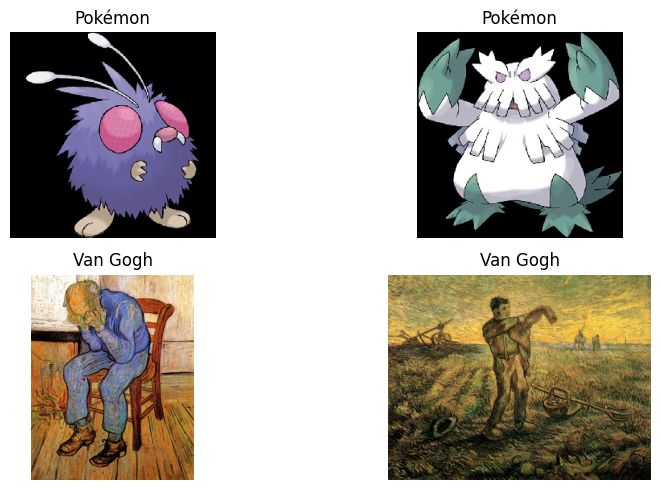

In [19]:
class ImageDataset(Dataset):
    def __init__(self, root_pokemon, root_painter, transform=None, limit=None):
        self.transform = transform
        self.files_pokemon = [os.path.join(root_pokemon, f) for f in os.listdir(root_pokemon) if f.endswith(('.png', '.jpg'))][:limit]
        self.files_painter = [os.path.join(root_painter, f) for f in os.listdir(root_painter) if f.endswith(('.png', '.jpg'))]

    def __getitem__(self, index):
        item_pokemon = self.transform(Image.open(self.files_pokemon[index % len(self.files_pokemon)]).convert('RGB'))
        item_painter = self.transform(Image.open(self.files_painter[index % len(self.files_painter)]).convert('RGB'))
        return {'A': item_pokemon, 'B': item_painter}

    def __len__(self):
        return max(len(self.files_pokemon), len(self.files_painter))
    
 # Função de visualização sem transformações
def visualize_random_images(pokemon_dir, painter_dir, num_images=2):
    pokemon_images = [os.path.join(pokemon_dir, f) for f in os.listdir(pokemon_dir) if f.endswith(('.png', '.jpg'))]
    painter_images = [os.path.join(painter_dir, f) for f in os.listdir(painter_dir) if f.endswith(('.png', '.jpg'))]

    random_pokemon_images = random.sample(pokemon_images, num_images)
    random_painter_images = random.sample(painter_images, num_images)

    fig, axes = plt.subplots(2, num_images, figsize=(10, 5))

    for i, img_path in enumerate(random_pokemon_images):
        img = Image.open(img_path).convert('RGB')
        axes[0, i].imshow(img)
        axes[0, i].set_title('Pokémon')
        axes[0, i].axis('off')

    for i, img_path in enumerate(random_painter_images):
        img = Image.open(img_path).convert('RGB')
        axes[1, i].imshow(img)
        axes[1, i].set_title('Van Gogh')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar as imagens aleatórias
visualize_random_images(pokemon_directory, van_gogh_directory)


### 3.4 Criação dos DataLoaders
Os DataLoaders são criados para carregar as imagens durante o treino, garantindo que são embaralhadas.

In [ ]:
pokemon_limit = 100
dataloader = DataLoader(ImageDataset(pokemon_directory, van_gogh_directory, transform=transform, limit=pokemon_limit), batch_size=1, shuffle=True, num_workers=0)

## 4. Arquitetura dos Modelos
Nesta secção, detalha-se a arquitetura das redes geradoras e discriminadoras utilizadas.

### 4.1 Gerador
O gerador transforma uma imagem de um domínio para outro, neste caso, de Pokémon para um estilo de pintura. A arquitetura do gerador é composta por uma camada inicial de convolução, seguida por camadas de downsampling, blocos residuais, camadas de upsampling e uma camada de saída.

In [3]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc):
        super(Generator, self).__init__()

        # Bloco de convolução inicial
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Blocos residuais
        for _ in range(6):
            model += [
                nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(in_features),
                nn.ReLU(inplace=True)
            ]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.BatchNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Camada de saída
        model += [nn.Conv2d(64, output_nc, kernel_size=7, padding=3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

### 4.2 Discriminador
O discriminador distingue entre imagens reais e geradas. A arquitetura do discriminador é composta por várias camadas de convolução que reduzem progressivamente a dimensão da imagem, até uma camada final que produz um mapa de probabilidade indicando se as regiões da imagem são reais ou falsas.

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        in_features = 64
        out_features = in_features * 2
        for _ in range(3):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        model += [nn.Conv2d(in_features, 1, kernel_size=4, stride=1, padding=1, bias=False)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


### Mostrar a Arquitetura dos Modelos

Para este trabalho, utilizou-se apenas a transformação de Pokémon para o estilo de pinturas de Van Gogh. A transformação inversa (pinturas de Van Gogh para Pokémon) será considerada para trabalhos futuros.


In [43]:
print('Generator:')
summary(Generator(3, 3).to(device), (3, 256, 256))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         294,912
       BatchNorm2d-8          [-1, 256, 64, 64]             512
              ReLU-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 256, 64, 64]         589,824
      BatchNorm2d-11          [-1, 256, 64, 64]             512
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         589,824
      BatchNorm2d-14        

In [44]:
print('Discriminator:')
summary(Discriminator(3).to(device), (3, 256, 256))

Discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 1, 15, 15]           8,192
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0
------------

## 5. Inicialização e Treino do Modelo
Nesta secção, inicializam-se e treinam-se os modelos.

### 5.1 Inicialização dos Pesos
Inicializam-se os pesos das redes para garantir uma distribuição normal. Esta técnica é importante para assegurar que os pesos começam com valores que permitem ao modelo aprender de forma eficiente.

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


### 5.2 Definição das Funções de Perda
Utilizam-se três funções de perda diferentes:

- criterion_GAN: Mede a diferença entre as previsões do discriminador para imagens reais e geradas, usando Mean Squared Error (MSE).
- criterion_cycle: Calcula a diferença entre a imagem original e a imagem reconstruída após passar pelo gerador de ida e volta, utilizando L1 Loss. Esta perda garante que a imagem reconstruída seja semelhante à original.
- criterion_identity: Verifica se o gerador mantém a identidade da imagem quando a imagem de destino é fornecida como entrada, utilizando L1 Loss.

In [6]:
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)


### 5.3 Inicialização dos Modelos e Otimizadores
Inicializam-se os modelos e otimizadores necessários para o treino.

In [7]:
netG_A2B = Generator(input_nc=3, output_nc=3).to(device)
netG_B2A = Generator(input_nc=3, output_nc=3).to(device)
netD_A = Discriminator(input_nc=3).to(device)
netD_B = Discriminator(input_nc=3).to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

optimizer_G = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=100, gamma=0.5)
scheduler_D_A = optim.lr_scheduler.StepLR(optimizer_D_A, step_size=100, gamma=0.5)
scheduler_D_B = optim.lr_scheduler.StepLR(optimizer_D_B, step_size=100, gamma=0.5)


## 6. Ciclo de Treino
Nesta secção, descreve-se o ciclo de treino do modelo. Cada época envolve os seguintes passos:

1. Geradores: Atualizam-se os geradores para gerar imagens que enganam os discriminadores.

- Identidade: A imagem gerada a partir da imagem de destino deve ser igual à própria imagem de destino.
- Adversarial: A imagem gerada deve ser classificada como real pelo discriminador.
- Ciclo: A imagem original deve ser recuperada após passar pelos dois geradores (ciclo de ida e volta).

2. Discriminadores: Atualizam-se os discriminadores para distinguir entre imagens reais e geradas.

- A imagem real deve ser classificada como real.
- A imagem gerada deve ser classificada como falsa.
3. Atualização dos Otimizadores: Os otimizadores são atualizados após o cálculo das perdas.

### 6.1 Treino Principal
Treina-se o modelo ao longo de várias épocas utilizando o ciclo de treino definido.

O treino foi efetuado com 100 épocas, o qual demorou 134 minutos a correr. Os valores loss foram guardados para no fim serem discutidos.

In [8]:
# Função para calcular a média móvel
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, 'valid')
    return sma

# Função para mostrar as perdas
def plot_losses(losses, window_size=50):
    min_len = min(len(losses['D_A']), len(losses['D_B']), len(losses['G']))
    loss_D_A_smooth = moving_average(losses['D_A'][:min_len], window_size)
    loss_D_B_smooth = moving_average(losses['D_B'][:min_len], window_size)
    loss_G_smooth = moving_average(losses['G'][:min_len], window_size)
    steps = range(1, len(loss_D_A_smooth) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(steps, loss_D_A_smooth, label='Loss D_A')
    plt.xlabel('Step')
    plt.ylabel('Loss D_A')
    plt.title('Loss D_A (Smoothed)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(steps, loss_D_B_smooth, label='Loss D_B')
    plt.xlabel('Step')
    plt.ylabel('Loss D_B')
    plt.title('Loss D_B (Smoothed)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(steps, loss_G_smooth, label='Loss G')
    plt.xlabel('Step')
    plt.ylabel('Loss G')
    plt.title('Loss G (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Variáveis para armazenar as perdas
losses = {'D_A': [], 'D_B': [], 'G': []}

def train_epoch(epoch, dataloader, netG_A2B, netG_B2A, netD_A, netD_B, optimizer_G, optimizer_D_A, optimizer_D_B, criterion_GAN, criterion_cycle, criterion_identity, device):
    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        valid = torch.ones((real_A.size(0), *netD_A(real_A).shape[1:]), requires_grad=False).to(device)
        fake = torch.zeros((real_A.size(0), *netD_A(real_A).shape[1:]), requires_grad=False).to(device)

        optimizer_G.zero_grad()

        loss_id_A = criterion_identity(netG_B2A(real_A), real_A) * 5.0
        loss_id_B = criterion_identity(netG_A2B(real_B), real_B) * 5.0

        fake_B = netG_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(netD_B(fake_B), valid)
        fake_A = netG_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(netD_A(fake_A), valid)

        rec_A = netG_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A) * 10.0
        rec_B = netG_A2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B) * 10.0

        loss_G = loss_id_A + loss_id_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        optimizer_G.step()

        optimizer_D_A.zero_grad()
        loss_real_A = criterion_GAN(netD_A(real_A), valid)
        loss_fake_A = criterion_GAN(netD_A(fake_A.detach()), fake)
        loss_D_A = (loss_real_A + loss_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        loss_real_B = criterion_GAN(netD_B(real_B), valid)
        loss_fake_B = criterion_GAN(netD_B(fake_B.detach()), fake)
        loss_D_B = (loss_real_B + loss_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                  f'Loss D_A: {loss_D_A.item():.4f}, Loss D_B: {loss_D_B.item():.4f}, '
                  f'Loss G: {loss_G.item():.4f}')

    # Armazenar as perdas após cada época
    losses['D_A'].append(loss_D_A.item())
    losses['D_B'].append(loss_D_B.item())
    losses['G'].append(loss_G.item())

    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()

# Treino Principal
num_epochs = 100
pokemon_limit = 100
dataloader = DataLoader(ImageDataset(pokemon_directory, van_gogh_directory, transform=transform, limit=pokemon_limit), batch_size=1, shuffle=True, num_workers=0)

for epoch in range(num_epochs):
    train_epoch(epoch, dataloader, netG_A2B, netG_B2A, netD_A, netD_B, optimizer_G, optimizer_D_A, optimizer_D_B, criterion_GAN, criterion_cycle, criterion_identity, device)

Epoch [1/100], Step [10/143], Loss D_A: 1.0888, Loss D_B: 1.4035, Loss G: 17.0447
Epoch [1/100], Step [20/143], Loss D_A: 0.7549, Loss D_B: 1.4329, Loss G: 12.9580
Epoch [1/100], Step [30/143], Loss D_A: 0.3404, Loss D_B: 0.7799, Loss G: 11.6685
Epoch [1/100], Step [40/143], Loss D_A: 0.2577, Loss D_B: 0.4725, Loss G: 10.0215
Epoch [1/100], Step [50/143], Loss D_A: 0.1832, Loss D_B: 0.4889, Loss G: 9.5822
Epoch [1/100], Step [60/143], Loss D_A: 0.4153, Loss D_B: 0.3399, Loss G: 10.9383
Epoch [1/100], Step [70/143], Loss D_A: 0.3248, Loss D_B: 0.3691, Loss G: 9.0027
Epoch [1/100], Step [80/143], Loss D_A: 0.1930, Loss D_B: 0.2946, Loss G: 8.1933
Epoch [1/100], Step [90/143], Loss D_A: 0.3027, Loss D_B: 0.3198, Loss G: 8.5670
Epoch [1/100], Step [100/143], Loss D_A: 0.1970, Loss D_B: 0.2158, Loss G: 7.1207
Epoch [1/100], Step [110/143], Loss D_A: 0.2332, Loss D_B: 0.1976, Loss G: 8.6199
Epoch [1/100], Step [120/143], Loss D_A: 0.3522, Loss D_B: 0.4396, Loss G: 8.5103
Epoch [1/100], Step 

## 7. Visualização e Guarda dos Resultados e Modelos

### 7.1 Modelos
Após o término do treino, os modelos gerados foram guardados para utilização futura. Isto inclui os geradores e discriminadores, tanto no sentido A para B quanto no sentido B para A. Guardar os modelos permite que sejam carregados posteriormente para realizar inferências ou continuar o treino a partir do ponto onde parou.

Os modelos foram guardados nos seguintes ficheiros:
- Gerador A para B (`netG_A2B.pth`)
- Gerador B para A (`netG_B2A.pth`)
- Discriminador A (`netD_A.pth`)
- Discriminador B (`netD_B.pth`)

A diretoria para armazenar os modelos é `./saved_models`.

O código utilizado para guardar os modelos é o seguinte:

In [23]:
# Diretoria para guardar os modelos
model_dir = './saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Guardar os modelos
torch.save(netG_A2B.state_dict(), os.path.join(model_dir, 'netG_A2B.pth'))
torch.save(netG_B2A.state_dict(), os.path.join(model_dir, 'netG_B2A.pth'))
torch.save(netD_A.state_dict(), os.path.join(model_dir, 'netD_A.pth'))
torch.save(netD_B.state_dict(), os.path.join(model_dir, 'netD_B.pth'))

print("Modelos guardados em:", model_dir)


Modelos guardados em: ./saved_models


### 7.2 Gráficos de Perdas

Os gráficos abaixo mostram a evolução das perdas do discriminador A (Loss D_A), do discriminador B (Loss D_B) e do gerador (Loss G) ao longo do treino.

**Loss D_A (Smoothed)**:
- Este gráfico mostra a perda do discriminador A ao longo do treino.
- Observa-se uma diminuição geral da perda com algumas flutuações ao longo do tempo.
- As flutuações são esperadas devido à natureza adversarial do treino GAN, onde o discriminador e o gerador se desafiam mutuamente.

**Loss D_B (Smoothed)**:
- Este gráfico mostra a perda do discriminador B.
- Semelhante à perda do discriminador A, também apresenta uma tendência decrescente com flutuações.
- A diminuição da perda sugere que o discriminador B está a melhorar na distinção entre imagens reais e geradas.

**Loss G (Smoothed)**:
- Este gráfico apresenta a perda do gerador.
- Uma perda menor indica que o gerador está a melhorar na criação de imagens que são convincentes para os discriminadores.
- Observa-se uma tendência geral de redução na perda, indicando melhorias no desempenho do gerador ao longo do treino.

Os valores de perda foram suavizados usando uma média móvel para facilitar a visualização da tendência geral. Isto ajuda a reduzir o ruído e permite uma análise mais clara da performance dos modelos.

#### Interpretação dos Resultados

- **Diminuição Geral das Perdas**: A diminuição geral das perdas D_A e D_B sugere que os discriminadores estão a melhorar a sua capacidade de distinguir entre imagens reais e geradas.
- **Melhoria do Gerador**: A perda do gerador (Loss G) mostra uma tendência decrescente, indicando que o gerador está a produzir imagens que se tornam progressivamente mais convincentes para os discriminadores.
- **Flutuações**: As flutuações nas perdas são normais devido à natureza adversarial do treino GAN, onde os modelos estão constantemente a tentar superar-se mutuamente.

Estes resultados indicam que o treino está a evoluir conforme esperado, com melhorias contínuas nos modelos tanto dos discriminadores quanto do gerador.


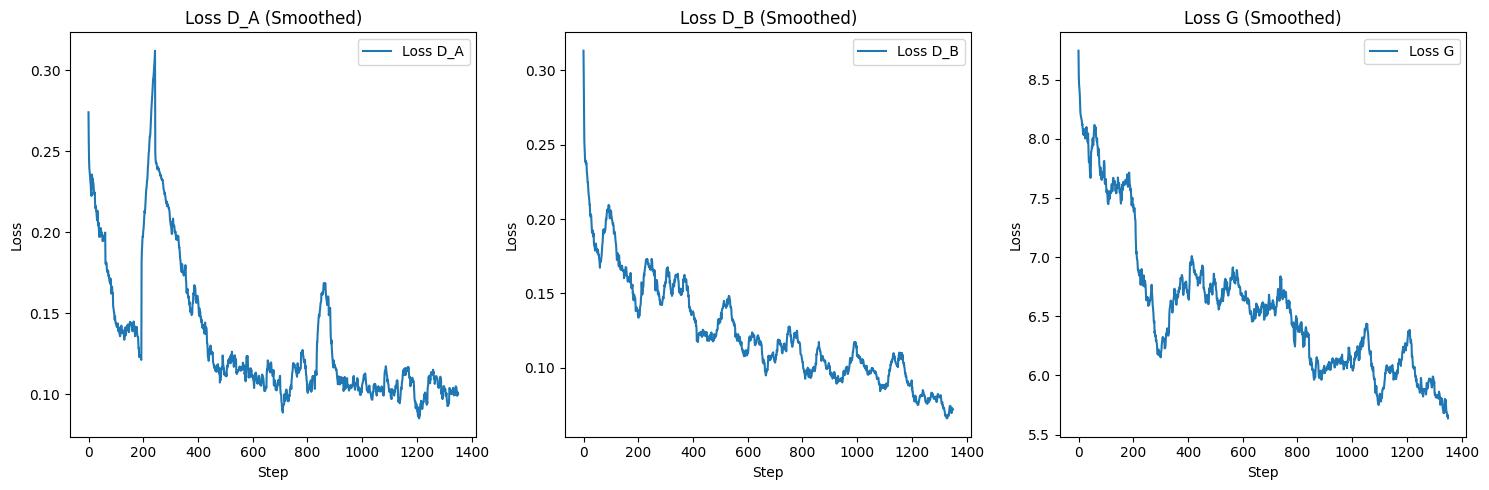

In [21]:
plot_losses(losses)

### 7.3 Visualização das Imagens
Para verificar a qualidade das imagens geradas pelo modelo, visualizámos algumas das imagens geradas. A função `visualize_random_results` foi utilizada para selecionar aleatoriamente 4 imagens do conjunto de dados, onde cada linha do gráfico mostra a imagem original do Pokémon e a imagem gerada com o estilo de Van Gogh.

Esta abordagem permite uma verificação visual rápida da qualidade das imagens geradas e garante que os modelos estão a funcionar conforme esperado.

A função para visualizar os resultados é a seguinte:

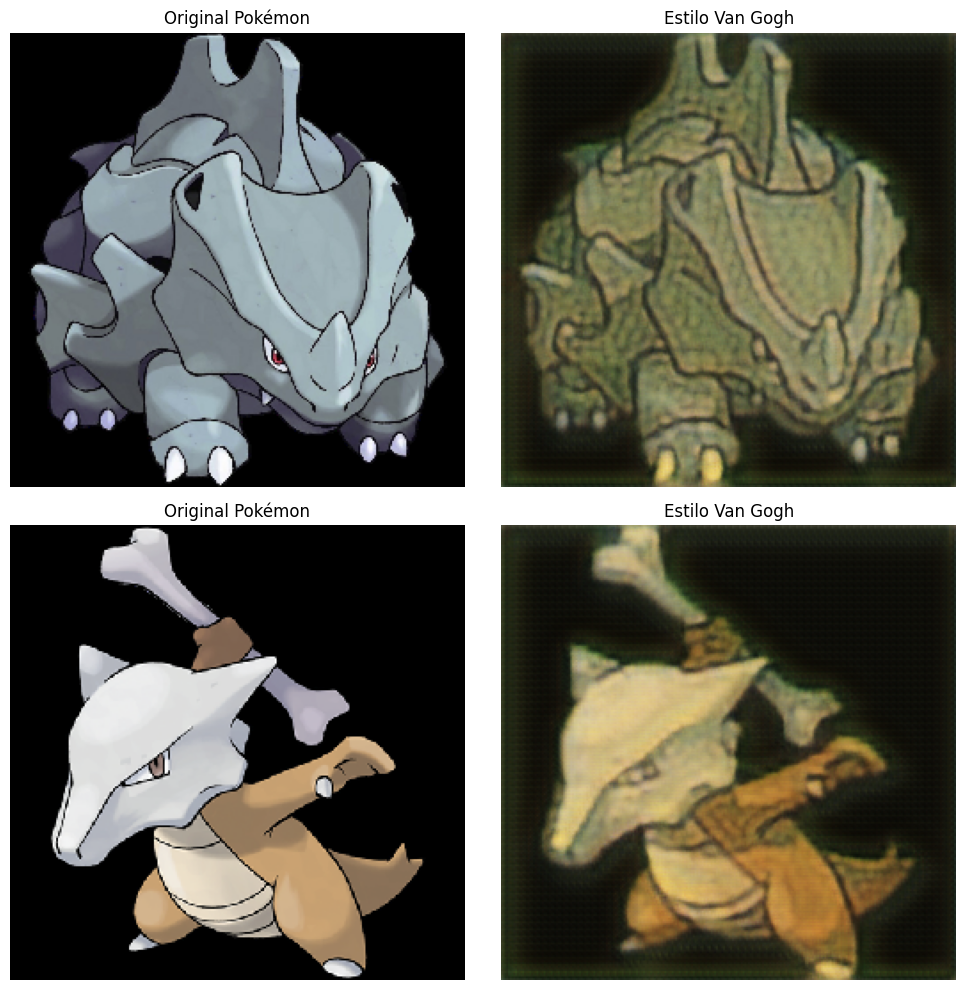

In [36]:
import random

def denormalize(tensor):
    return tensor * 0.5 + 0.5

def visualize_random_results(dataloader, netG_A2B, num_images=4):
    netG_A2B.eval()
    with torch.no_grad():
        all_batches = list(dataloader)
        random_batches = random.sample(all_batches, num_images // 2)  # Selecionar batches aleatórios
        fig, axs = plt.subplots(num_images // 2, 2, figsize=(10, 5 * (num_images // 2)))

        for i, batch in enumerate(random_batches):
            real_A = batch['A'].to(device)
            fake_B = netG_A2B(real_A)

            for j in range(2):  # Considerando que queremos mostrar 2 imagens por linha
                ax = axs[i][j] if num_images > 2 else axs[j]

                if j % 2 == 0:
                    ax.imshow(transforms.ToPILImage()(denormalize(real_A[j % len(real_A)]).cpu()))
                    ax.set_title('Original Pokémon')
                else:
                    ax.imshow(transforms.ToPILImage()(denormalize(fake_B[j % len(fake_B)]).cpu()))
                    ax.set_title('Estilo Van Gogh')

                ax.axis('off')

        plt.tight_layout()
        plt.show()

visualize_random_results(dataloader, netG_A2B, num_images=4)


Código para Guardar e visualizar os resultados de várias imagens.

In [ ]:
def denormalize(tensor):
    return tensor * 0.5 + 0.5

def visualize_results(dataloader, netG_A2B, output_dir):
    netG_A2B.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            real_A = batch['A'].to(device)
            fake_B = netG_A2B(real_A)

            for j in range(len(real_A)):
                fig, ax = plt.subplots(1, 2, figsize=(10, 5))

                ax[0].imshow(transforms.ToPILImage()(denormalize(real_A[j]).cpu()))
                ax[0].set_title('Original Pokémon')
                ax[0].axis('off')

                ax[1].imshow(transforms.ToPILImage()(denormalize(fake_B[j]).cpu()))
                ax[1].set_title('Estilo Van Gogh')
                ax[1].axis('off')

                plt.tight_layout()
                plt.show()

                output_path = os.path.join(output_dir, f'img_{i+1}_{j+1}.png')
                fig.savefig(output_path)
                plt.close(fig)

output_dir = './output_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

visualize_results(dataloader, netG_A2B, output_dir)

## 8. Comparação com Resultados Publicados por Terceiros

Para avaliar a eficácia do modelo desenvolvido, é feita uma comparação com resultados obtidos por terceiros em trabalhos semelhantes que utilizaram GANs para transferência de estilo.

### Pix2Pix vs. CycleGAN

O trabalho de Isola et al. (2017) com Pix2Pix apresentou resultados impressionantes na transferência de estilo, mas exigia pares de imagens correspondentes para treino. Em contrapartida, Zhu et al. (2017) desenvolveram o CycleGAN para superar esta limitação, permitindo a transferência de estilo sem a necessidade de pares de imagens.

### Resultados do Presente Trabalho

- **Perdas**: As perdas dos discriminadores e geradores diminuíram ao longo do treino, similarmente ao observado nos trabalhos mencionados. Em particular, as flutuações nas perdas são consistentes com a natureza adversarial do treino, conforme descrito por Zhu et al. (2017).
- **Qualidade das Imagens Geradas**: A qualidade das imagens geradas pelo modelo CycleGAN foi avaliada visualmente. As imagens estilizadas apresentaram características visuais do estilo Van Gogh, indicando que o modelo aprendeu a mapear corretamente as características do estilo.

### Comparação com Resultados Publicados

- **Pix2Pix (Isola et al., 2017)**: No trabalho com Pix2Pix, a necessidade de pares de imagens limitava a aplicabilidade em cenários onde tais pares não estão disponíveis. O presente trabalho com CycleGAN superou esta limitação, permitindo a transferência de estilo sem a necessidade de pares correspondentes.
- **CycleGAN (Zhu et al., 2017)**: O presente trabalho produziu resultados visualmente comparáveis aos apresentados por Zhu et al., com a vantagem adicional de demonstrar a aplicabilidade em um conjunto de dados específico (Pokémon e Van Gogh). As perdas ao longo do treino mostraram uma tendência decrescente, similar aos padrões observados no trabalho original do CycleGAN.

### Avaliação Quantitativa

- **FID Score**: No trabalho de Zhu et al., a avaliação quantitativa das imagens geradas foi realizada utilizando o Fréchet Inception Distance (FID). Para uma comparação quantitativa mais rigorosa, seria interessante calcular o FID para as imagens geradas e compará-lo com os valores reportados por Zhu et al. (2017).

### Conclusão da Comparação

Os resultados do presente trabalho estão alinhados com os resultados apresentados por Zhu et al. (2017), demonstrando a eficácia do CycleGAN para transferência de estilo sem pares de imagens correspondentes. A principal vantagem deste trabalho é a aplicação bem-sucedida do CycleGAN em um novo conjunto de dados, mostrando a versatilidade e robustez do modelo.

Referências:
- Isola, P., Zhu, J.-Y., Zhou, T., & Efros, A. A. (2017). Image-to-Image Translation with Conditional Adversarial Networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR).
- Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. In Proceedings of the IEEE International Conference on Computer Vision (ICCV).


## 9. Conclusão e Trabalhos Futuros

### Conclusão

Neste projeto, foi utilizado o modelo CycleGAN para realizar a transferência de estilo de imagens de Pokémon para o estilo de pinturas de Van Gogh. O processo incluiu a preparação dos datasets, a definição das arquiteturas dos geradores e discriminadores, e o treino do modelo. As perdas foram monitorizadas ao longo do treino, observando-se uma diminuição geral nas perdas, indicando que os modelos estavam a melhorar.

Visualizou-se o resultado final das transformações, onde as imagens de Pokémon foram estilizadas no estilo de Van Gogh, comprovando a eficácia do modelo treinado.

### Trabalhos Futuros

Para trabalhos futuros, várias melhorias e extensões podem ser consideradas:
- **Aumento do Dataset**: Utilizar um dataset maior e mais variado pode ajudar a melhorar a qualidade das imagens geradas.
- **Ajustes de Hiperparâmetros**: Experimentar com diferentes hiperparâmetros, como a taxa de aprendizagem, o número de épocas e o tamanho dos lotes, para otimizar ainda mais o desempenho do modelo.
- **Exploração de Outras Arquiteturas**: Investigar outras arquiteturas de GANs ou mesmo Autoencoders para ver se oferecem melhores resultados para este tipo de tarefa.
- **Aplicação de Técnicas de Regularização**: Implementar técnicas de regularização como Dropout ou técnicas avançadas como Spectral Normalization para melhorar a estabilidade do treino.
- **Avaliação Quantitativa**: Implementar métricas quantitativas para avaliar a qualidade das imagens geradas, como o Fréchet Inception Distance (FID) ou o Inception Score (IS).

A abordagem apresentada neste trabalho pode ser aplicada a outras tarefas de transferência de estilo e oferece um ponto de partida sólido para investigações futuras.
